# Tutorial 1: Bistable 1D System

This tutorial demonstrates how to use the Separatrix Locator to find separatrices in a simple 1D bistable system.

The system is defined by:
$$
\frac{dx}{dt} = x - x^3
$$

This system has:
- Two stable fixed points at $x = \pm 1$
- One unstable fixed point (separatrix) at $x = 0$

## Learning Objectives
- Understand the basic workflow of separatrix location
- Learn how to set up a simple dynamical system
- Train Koopman eigenfunction models
- Locate separatrices using gradient descent


In [2]:
# Install the package when running in Colab
# !pip install torchdiffeq
# !pip install --no-deps git+https://github.com/KabirDabholkar/separatrix_locator.git

In [3]:
# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint

# Import the separatrix locator package
from separatrix_locator import SeparatrixLocator
from separatrix_locator.distributions import MultivariateGaussian
from separatrix_locator.utils import plot_trajectories, plot_separatrix

from torch import nn

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 1. Create the Dynamical System

First, let's create our bistable 1D system and examine its properties.


In [4]:
# Define the bistable 1D system directly as a vector field

def dynamics_func(x: torch.Tensor) -> torch.Tensor:
    """Return dx/dt for the bistable 1D system."""
    return x - x**3


dynamics_dim = 1
attractors = torch.tensor([[1.0], [-1.0]])
separatrix = torch.tensor([[0.0]])

print(f"Dimension: {dynamics_dim}")
print(f"Attractors: {attractors.tolist()}")
print(f"Separatrix guess: {separatrix.tolist()}")


Dimension: 1
Attractors: [[1.0], [-1.0]]
Separatrix guess: [[0.0]]


Text(0, 0.5, '$\\dot{x}$')

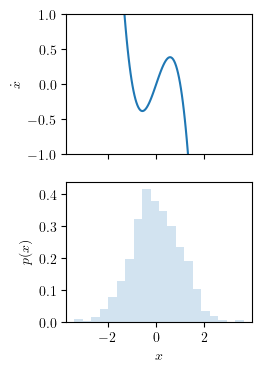

In [5]:
distribution = MultivariateGaussian(
    dim=1,
)
samples = distribution.sample(sample_shape=(1000,))
fig,axs = plt.subplots(2,1,sharex=True,figsize=(2.4,4))
x = torch.linspace(-2,2,100)[:None]
l=axs[0].plot(x,dynamics_func(x))
l=axs[0].set_ylim(-1,1)
l=axs[1].hist(samples.numpy(), bins=20, density=True,alpha=0.2)
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$p(x)$')
axs[0].set_ylabel(r'$\dot{x}$')


### Let's fit the Koopman Eigenfunction!

In [6]:
model = nn.Sequential(
    nn.Linear(dynamics_dim,200),
    nn.Tanh(),
    nn.Linear(200,200),
    nn.Tanh(),
    nn.Linear(200,1),
)


In [ ]:
model.to(device)
locator = SeparatrixLocator(
    models=[model],
    dynamics_dim=1,
    device=device,
    verbose=True,
    epochs=5000,
    
)
locator.fit(
    func=dynamics_func,
    distribution=distribution,
    batch_size=1000,
    balance_loss_lambda = 1e-2,
    eigenvalue=1.0,
    RHS_function=lambda phi: phi,
)

Training 1 models...
Training model 1/1


TypeError: 'str' object is not callable

In [ ]:
x_plot = torch.linspace(-2, 2, 200)[:, None].to(device)
with torch.no_grad():
    y_plot = model(x_plot).cpu().numpy().flatten()

# Analytical solution: x / abs(1-x^2)**0.5, but beware division by zero  
x_np = x_plot.cpu().numpy().flatten()
eps = 1e-8
denominator = np.abs(1 - x_np**2)
denominator[denominator < eps] = eps
analytical = x_np / (denominator**0.5)

# Determine best overall scale (including sign) for analytical solution to best match model
from numpy.linalg import lstsq

# Fit analytical * s ≈ model, sign will be absorbed into s
A = analytical[:, None]
b = y_plot
scale, _, _, _ = lstsq(A, b, rcond=None)
best_analytical = analytical * scale[0]

label = r'analytical'

plt.figure(figsize=(4,3))
plt.plot(x_np, y_plot, label='model(x)')
plt.plot(x_np, best_analytical, '--', label=label)
plt.xlabel(r'$x$')
plt.ylabel('model(x)')
plt.title('Model output vs x')
plt.legend()
plt.show()


### Squashed Koopman Eigenfunction

In [ ]:
model = nn.Sequential(
    nn.Linear(dynamics_dim,200),
    nn.Tanh(),
    nn.Linear(200,200),
    nn.Tanh(),
    nn.Linear(200,1),
)

model.to(device)
locator = SeparatrixLocator(
    models=[model],
    dynamics_dim=1,
    device=device,
    verbose=True,
    epochs=1000,
    
)
locator.fit(
    func=dynamics_func,
    distribution=distribution,
    batch_size=1000,
    balance_loss_lambda = 1e-2,
    eigenvalue=1.0,
    RHS_function=lambda phi: phi-phi**3,
)

In [ ]:
x_plot = torch.linspace(-2, 2, 200)[:, None].to(device)
with torch.no_grad():
    y_plot = model(x_plot).cpu().numpy().flatten()

# Analytical solution: x / abs(1-x^2)**0.5, but beware division by zero  
x_np = x_plot.cpu().numpy().flatten()
analytical = x_np 

# Determine best overall scale (including sign) for analytical solution to best match model
from numpy.linalg import lstsq

# Fit analytical * s ≈ model, sign will be absorbed into s
A = analytical[:, None]
b = y_plot
scale, _, _, _ = lstsq(A, b, rcond=None)
best_analytical = analytical * np.sign(scale[0])

label = r'analytical'

plt.figure(figsize=(4,3))
plt.plot(x_np, y_plot, label='model(x)')
plt.plot(x_np, best_analytical, '--', label=label)
plt.xlabel(r'$x$')
plt.ylabel('model(x)')
plt.title('Model output vs x')
plt.legend()
plt.show()
